In [1]:
# !pip3 install scikit-image
# !pip3 install tabulate
# !pip3 install torch
# !pip3 install opencv-python

In [2]:
import pandas as pd # importing pandas
import numpy as np # importing numpy
import matplotlib.pyplot as plt # importing plotting module
import random # importing random
from tabulate import tabulate # importing tabulate

# importing HED Space staining packages
from skimage.color import rgb2hed
import skimage
from skimage.io import imread

from sklearn.preprocessing import StandardScaler # importing pre-processing package
from sklearn.decomposition import PCA # importing package for PCA

from sklearn.model_selection import GridSearchCV # importing package for grid search

# importing packages for regression
from sklearn.linear_model import LinearRegression 
from sklearn.svm import SVR 
from sklearn.neural_network import MLPRegressor

# importing packages for regression performance metrices
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt
from scipy import stats

import cv2

# importing packages for pytorch
import torch
import torch.nn as nn
import torch.nn.functional as fun
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# import tqdm

from sklearn.model_selection import train_test_split # importing package for splitting the data

# Question 1: Data Analysis

### Load the training and test data files and answer the following questions:

In [3]:
X = np.load("images.npy") # read images
Y = pd.read_csv('counts.csv') # read cell counts
F = np.loadtxt('split.txt') # read fold information

In [4]:
# renaming the columns of the dataframe containing the cell counts for each cell type
Y.rename(columns = {
            "neutrophil":"T1",
            "epithelial":"T2",
            "lymphocyte":"T3",
            "plasma":"T4",
            "eosinophil":"T5",
            "connective":"T6"
        },
        inplace=True)
Y.head()

T1   T2  T3  T4  T5  T6
0   0  117   0   0   0   0
1   0   95   1   0   0   8
2   0  172   3   0   0   2
3   0   56   0   0   0  10
4   0  169   7   0   0   0

### i) How many examples are there in each fold?

In [5]:
print(f"Number of examples in the first fold: {np.count_nonzero(F == 1)}")
print(f"Number of examples in the second fold: {np.count_nonzero(F == 2)}")
print(f"Number of examples in the third fold: {np.count_nonzero(F == 3)}")

Number of examples in the first fold: 1622
Number of examples in the second fold: 1751
Number of examples in the third fold: 1608


#### There are 1622 examples in the first fold, 1751 examples in the second fold and 1608 examples in the third fold.

### ii) Show some image examples using plt.imshow. Describe your observations on what you see in the images and how it correlates with the cell counts of different types of cells and the overall number of cells.

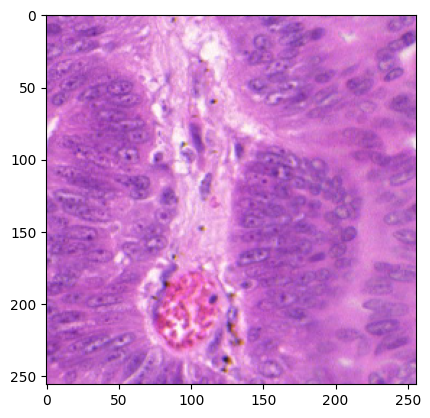

Cell counts for each cell type:
T1      0
T2    110
T3      1
T4      0
T5      0
T6     12
Name: 4868, dtype: int64
Total number of cells: 123


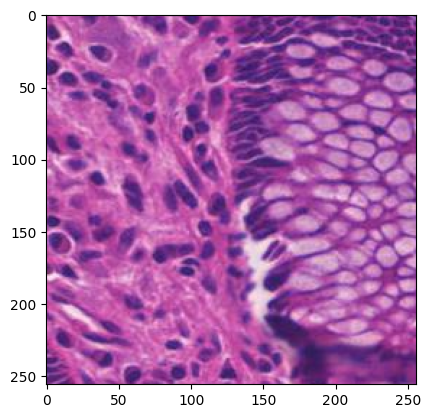

Cell counts for each cell type:
T1     0
T2    28
T3    21
T4    17
T5     0
T6    23
Name: 2740, dtype: int64
Total number of cells: 89


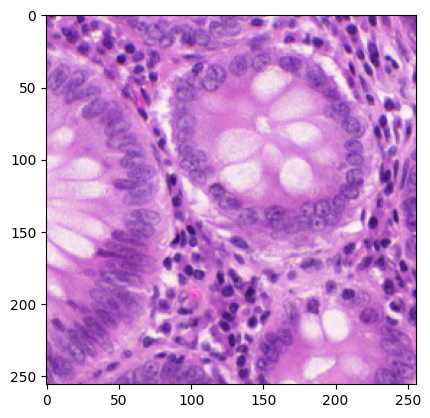

Cell counts for each cell type:
T1     0
T2    79
T3    47
T4    16
T5     0
T6    30
Name: 4309, dtype: int64
Total number of cells: 172


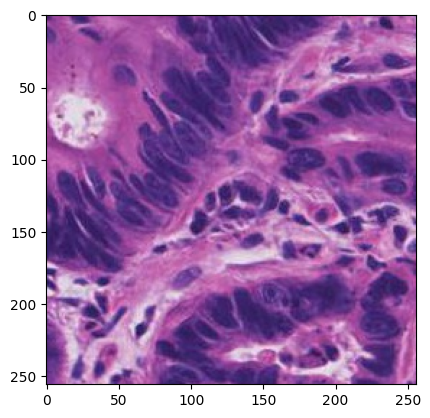

Cell counts for each cell type:
T1     1
T2    64
T3    14
T4     6
T5     0
T6    17
Name: 3783, dtype: int64
Total number of cells: 102


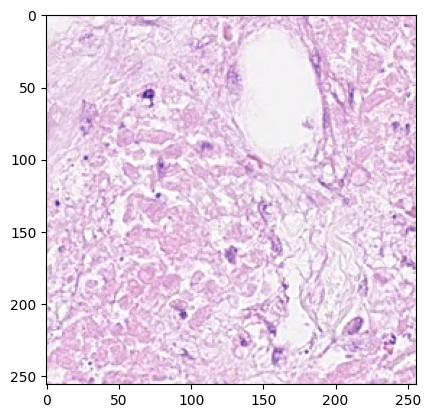

Cell counts for each cell type:
T1    0
T2    0
T3    1
T4    0
T5    0
T6    9
Name: 1845, dtype: int64
Total number of cells: 10


In [6]:
# randomly choosing 5 images
random_list=random.sample(range(Y.shape[0]),5)
for i in random_list:
    # finding the total number of cells in each image
    total_cells = Y.iloc[i,0]+Y.iloc[i,1]+Y.iloc[i,2]+Y.iloc[i,3]+Y.iloc[i,4]+Y.iloc[i,5]
    plt.imshow(X[i])
    plt.show()
    print("Cell counts for each cell type:")
    print(Y.iloc[i]) # cell count for each type of cell in each image
    print(f"Total number of cells: {total_cells}")

#### The long light pink cells seem to be the T6 cell i.e. connective cells. T2 i.e. epithelial cells seem to be the rounded cells with a slight purple hue.  The purple cells are the T3 i.e. lymphocyte cells. T2 cells seem to have a higher count and T1 cells seem to have a lower count in most figures than the rest.

### iii) For each fold, plot the histogram of counts of each cell type separately as well as the total number of cells (7 plots in total). How many images have counts within each of the following bins?

In [7]:
# creating new dataframes for the cell counts for images in different folds
cols = ["T1","T2","T3","T4","T5","T6"]
first_Y = pd.DataFrame(columns=cols)
second_Y = pd.DataFrame(columns=cols)
third_Y = pd.DataFrame(columns=cols)
for i,x in enumerate(F):
    if x == 1:
        first_Y=pd.concat([first_Y, Y[Y.index==i]])
    elif x == 2:
        second_Y=pd.concat([second_Y, Y[Y.index==i]])
    else:
        third_Y=pd.concat([third_Y, Y[Y.index==i]])

In [8]:
# finding the total number of cells in each image for each fold
def row_sum(row):
    return row.T1+row.T2+row.T3+row.T4+row.T5+row.T6

first_Y['Total'] = first_Y.apply(row_sum, axis=1)
second_Y['Total'] = second_Y.apply(row_sum, axis=1)
third_Y['Total'] = third_Y.apply(row_sum, axis=1)

Number of images(Frequencies) of different Cell Types for Fold 1
+----+---------------+------+------+------+------+------+------+---------+
|    |   Lower Limit |   T1 |   T2 |   T3 |   T4 |   T5 |   T6 |   Total |
+====+===============+======+======+======+======+======+======+=========+
|  0 |           0   | 1308 |  223 |  166 |  527 | 1179 |  105 |      39 |
+----+---------------+------+------+------+------+------+------+---------+
|  1 |           0.5 |  235 |   35 |  397 |  508 |  417 |  178 |      17 |
+----+---------------+------+------+------+------+------+------+---------+
|  2 |           5.5 |   40 |   46 |  216 |  267 |   25 |  209 |      15 |
+----+---------------+------+------+------+------+------+------+---------+
|  3 |          10.5 |   14 |   37 |  161 |  154 |    0 |  201 |      13 |
+----+---------------+------+------+------+------+------+------+---------+
|  4 |          15.5 |   14 |   45 |  132 |   68 |    1 |  192 |      10 |
+----+---------------+------+------

C:\Users\sarah\AppData\Local\Temp\ipykernel_14644\1581211486.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Number of images(Frequencies) of different Cell Types for Fold 3
+----+---------------+------+------+------+------+------+------+---------+
|    |   Lower Limit |   T1 |   T2 |   T3 |   T4 |   T5 |   T6 |   Total |
+====+===============+======+======+======+======+======+======+=========+
|  0 |           0   | 1333 |  348 |  274 |  694 | 1236 |  214 |      57 |
+----+---------------+------+------+------+------+------+------+---------+
|  1 |           0.5 |  234 |   57 |  484 |  508 |  331 |  234 |      31 |
+----+---------------+------+------+------+------+------+------+---------+
|  2 |           5.5 |   33 |   50 |  171 |  161 |   35 |  204 |      36 |
+----+---------------+------+------+------+------+------+------+---------+
|  3 |          10.5 |    5 |   68 |  162 |  102 |    5 |  185 |      41 |
+----+---------------+------+------+------+------+------+------+---------+
|  4 |          15.5 |    3 |   61 |  123 |   54 |    1 |  175 |      44 |
+----+---------------+------+------

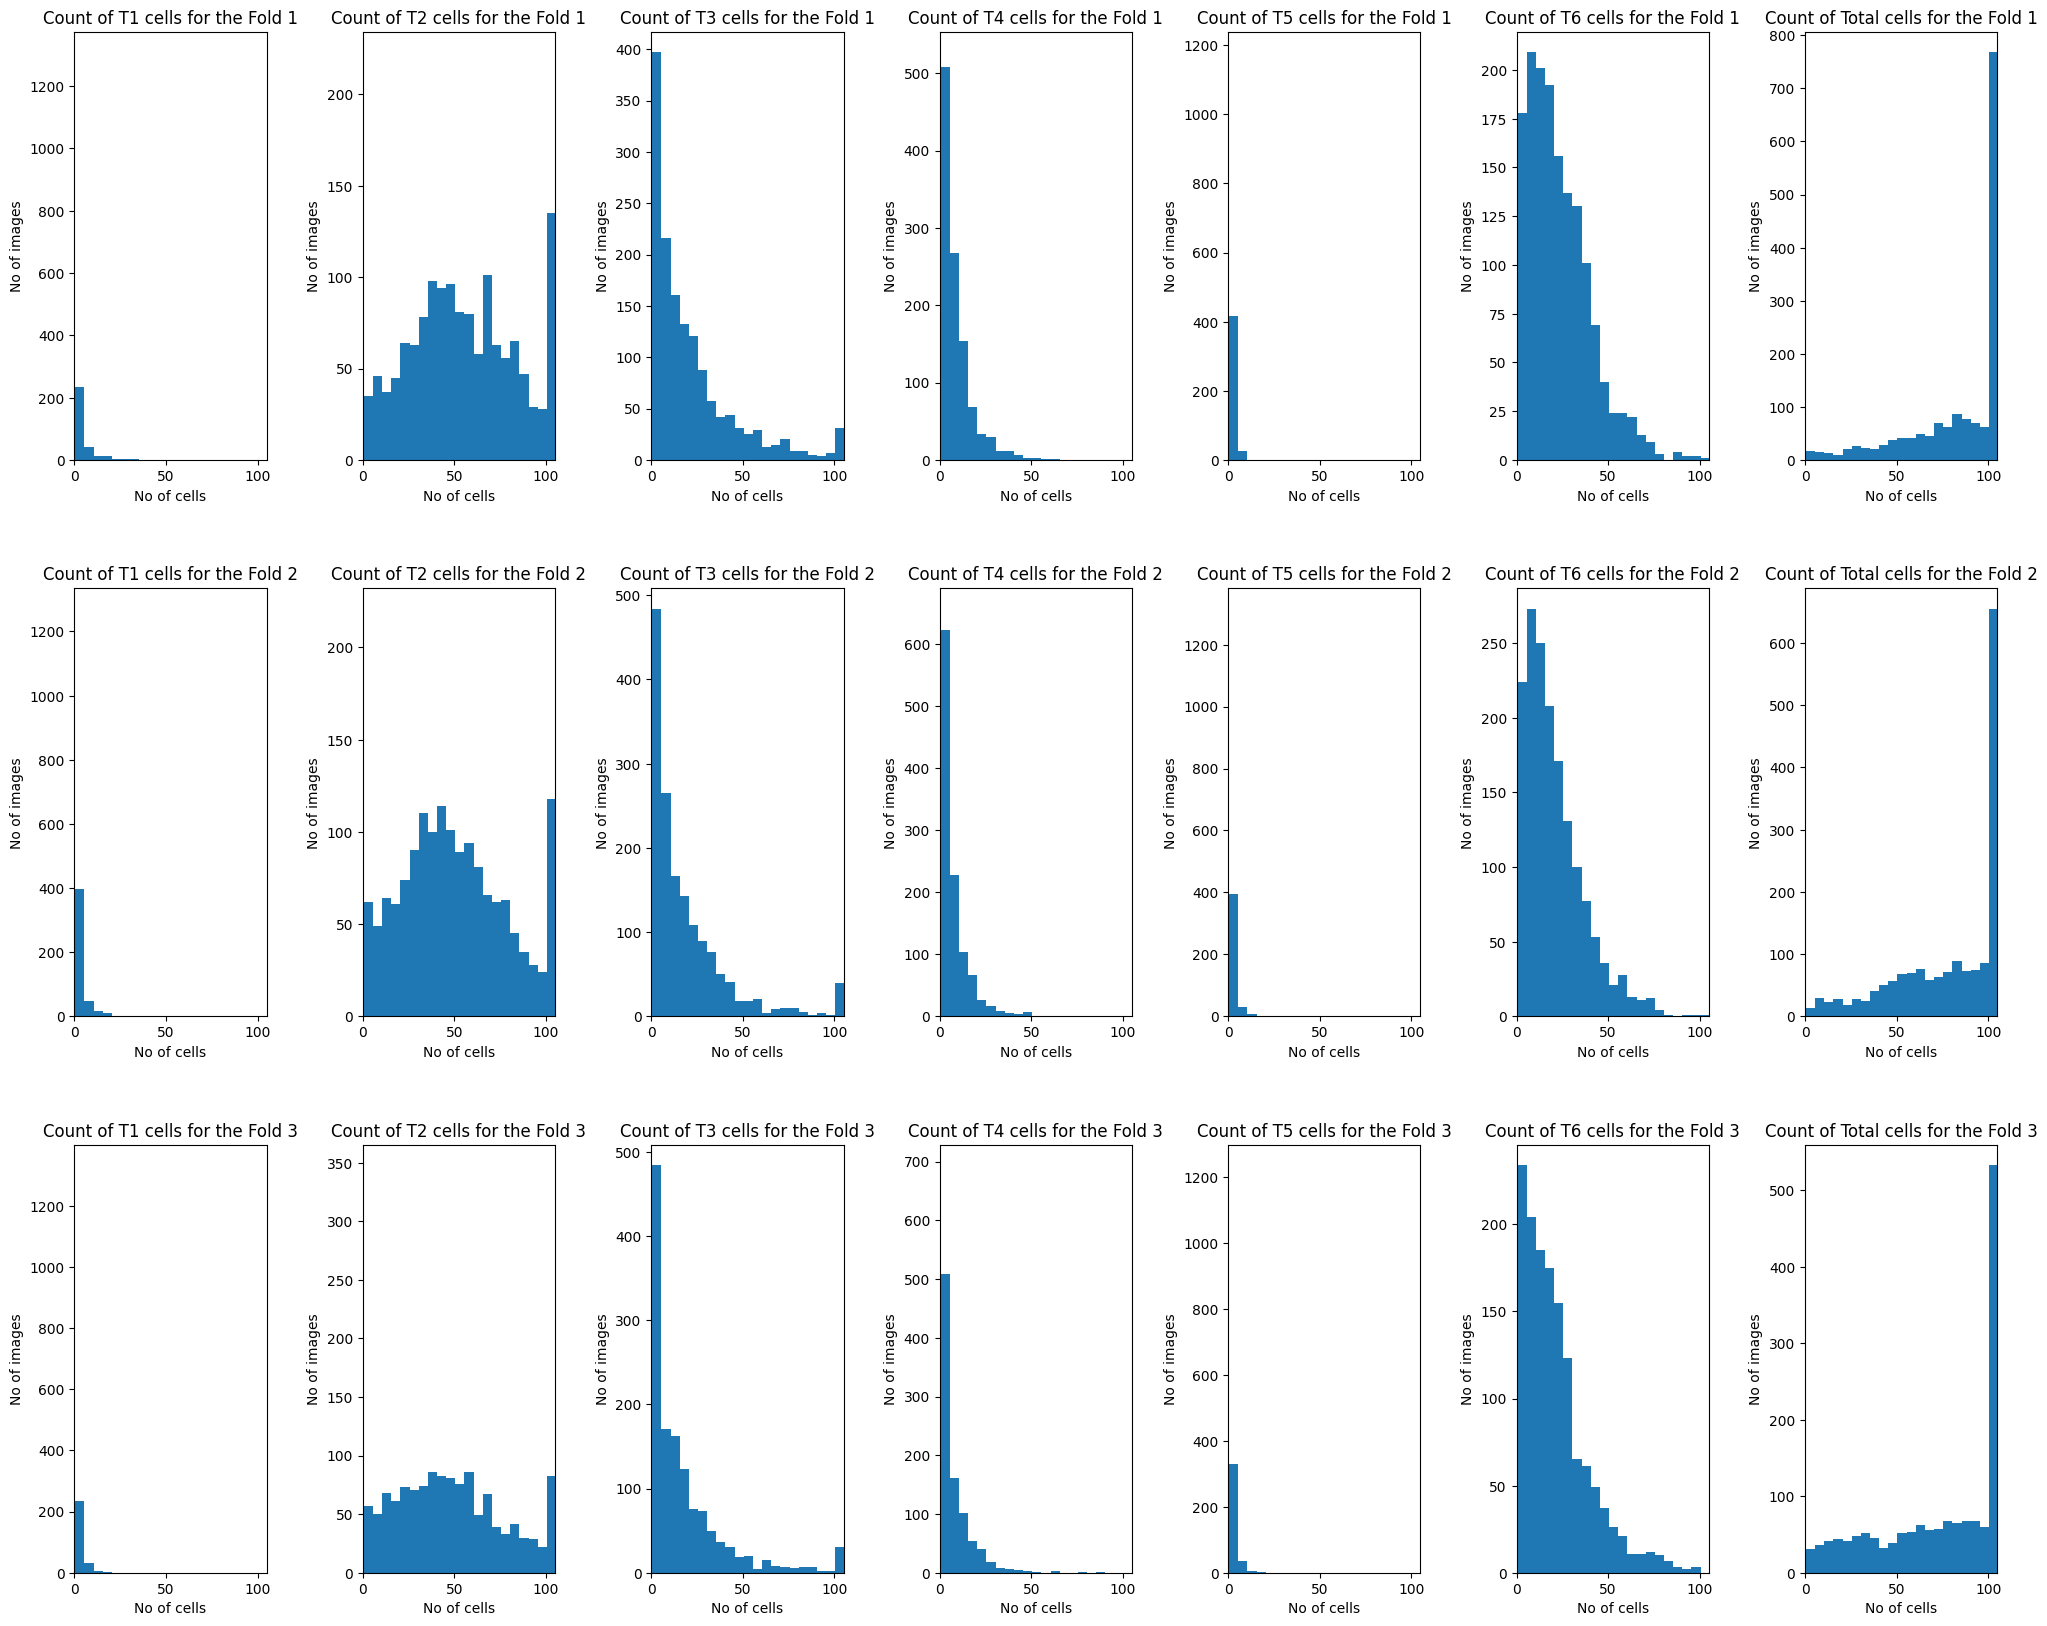

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [9]:
fig,ax = plt.subplots(3,7,figsize=(20, 16)) 
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace = 0.5)
list_dataset = [first_Y, second_Y, third_Y]
list_cell = ["T1","T2","T3","T4","T5","T6","Total"]
for idx, data in enumerate(list_dataset):
    freq=pd.DataFrame()
    for inx, cell in enumerate(list_cell):
        # creating custom bins
        bins=list(range(min(data[cell]), max(data[cell]) + 5, 5))
        bins=[i+0.5 for i in bins if (i<=100 or i >= max(data[cell]))]
        bins.insert(0,0)
        
        # plotting the Histogram
        plt.figure()
        n, interval, patches = ax[idx][inx].hist(data[cell], bins=bins)
        ax[idx][inx].set_xlabel("No of cells")
        ax[idx][inx].set_ylabel("No of images")
        ax[idx][inx].set_title(f"Count of {cell} cells for the Fold {idx+1}")
        ax[idx][inx].set_xlim([0, 105])
        
        # finding frequencies
        freq=pd.concat([freq, pd.Series(n)], axis=1)
    
    # frequency table
    freq.insert(0,"LL",pd.Series(interval))
    freq=freq.fillna(0)
    col_names = ["Lower Limit","T1","T2","T3","T4","T5","T6","Total"]
    print(f"Number of images(Frequencies) of different Cell Types for Fold {idx+1}")
    print(tabulate(freq, headers=col_names, tablefmt="grid"))
    print()

#### Since the interval (bins) are not continuous, adding 0.5 to the upper limit and subtracting 0.5 to the lower limit can change it to continuous limits. The tables show the lower limit of all bins (with the added 0.5) and the frequency (number of images) for each cells along with the total number of cells are shown.

### iv) Pre-processing: Convert and show a few images from RGB space to HED space and show the H-channel which should indicate cellular nuclei. 

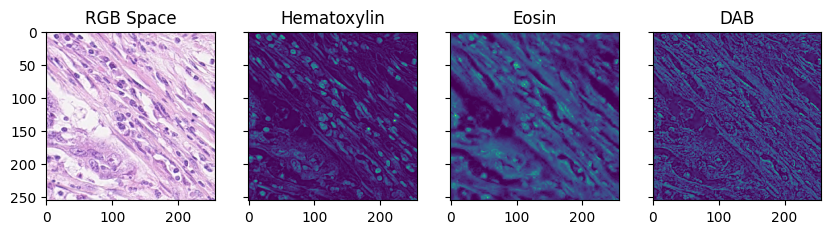

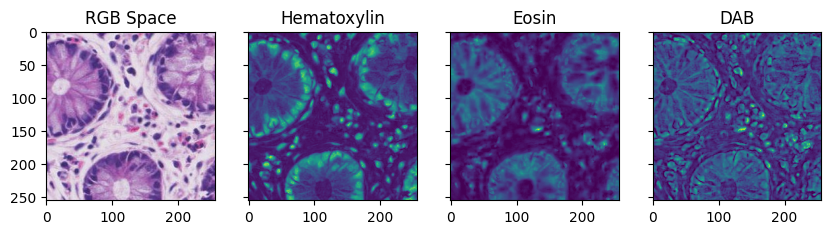

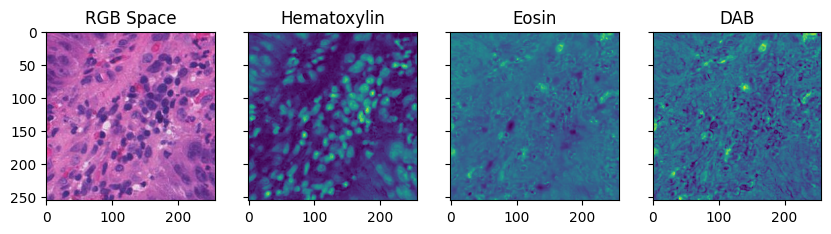

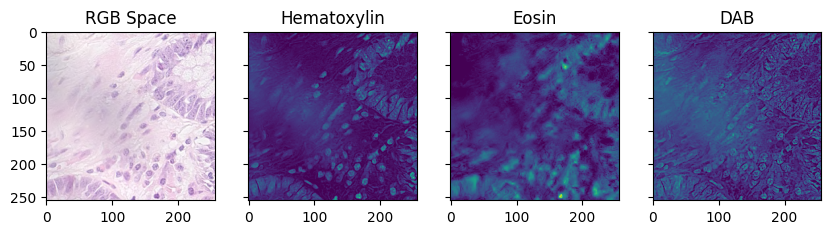

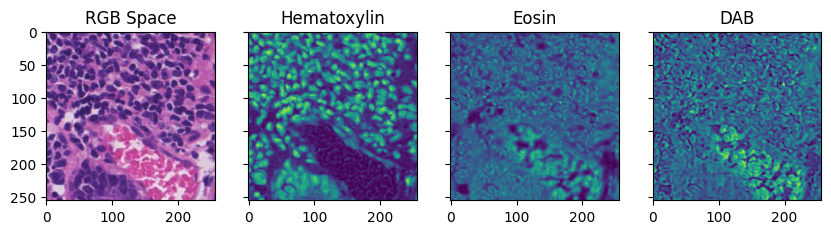

In [10]:
# randomly choosing 5 images
random_list = random.sample(range(0,Y.shape[0]+1),5)
for i in random_list:
    ihc_rgb = X[i]
    ihc_hed = rgb2hed(ihc_rgb)

    # Extracting HED Channels
    ihc_h = ihc_hed[:, :, 0]
    ihc_e = ihc_hed[:, :, 1]
    ihc_d = ihc_hed[:, :, 2]
    
    # Plotting the images in RGB and HED space
    fig, axes = plt.subplots(1, 4, figsize=(10, 10), sharex=True, sharey=True)
    ax = axes.ravel()
    ax[0].imshow(ihc_rgb)
    ax[0].set_title("RGB Space")
    ax[1].imshow(ihc_h)
    ax[1].set_title("Hematoxylin")
    ax[2].imshow(ihc_e)
    ax[2].set_title("Eosin")
    ax[3].imshow(ihc_d)
    ax[3].set_title("DAB")

#### The nuclei of the each image are visible in the H channel.

### v) Do a scatter plot of the average of the H-channel for each image vs. its cell count of a certain type and the total number of cells for images in Fold-1 (7 plots in total). Do you think this feature would be useful in your regression model? Explain your reasoning.

In [11]:
# average H channel for each image in the first fold
h_channel = []
for i,x in enumerate(F):
    if x == 1:
        hed = rgb2hed(X[i])
        avg = np.mean(hed[:, :, 0])
        h_channel.append(avg)

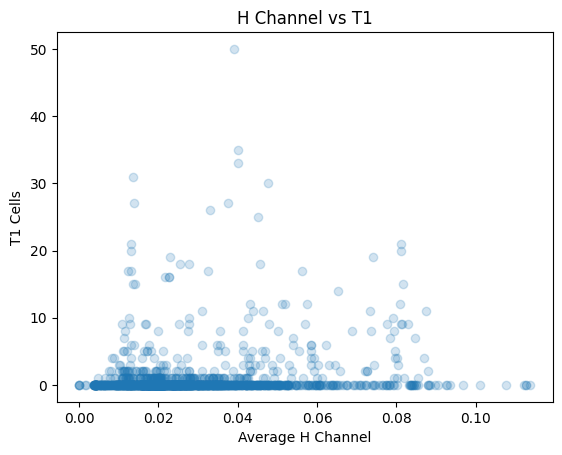

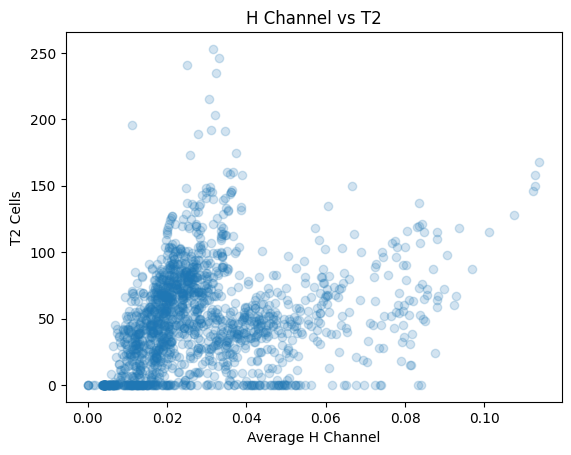

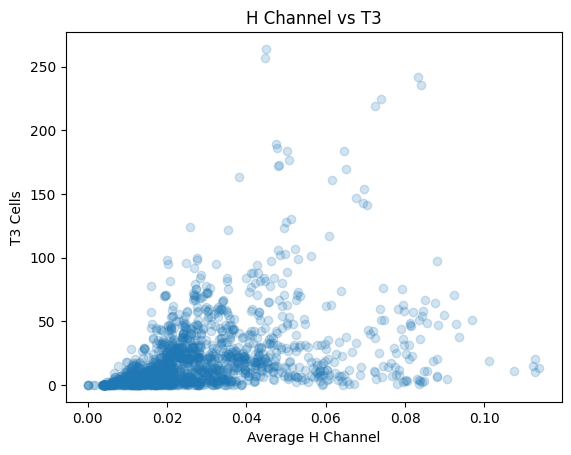

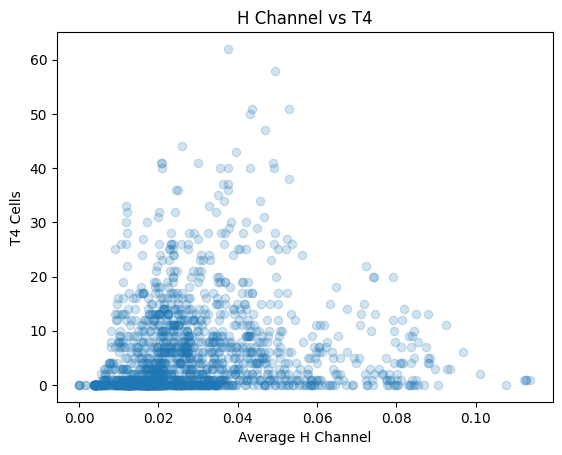

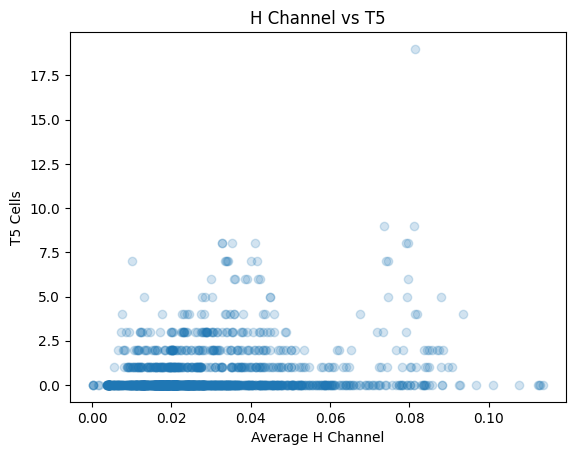

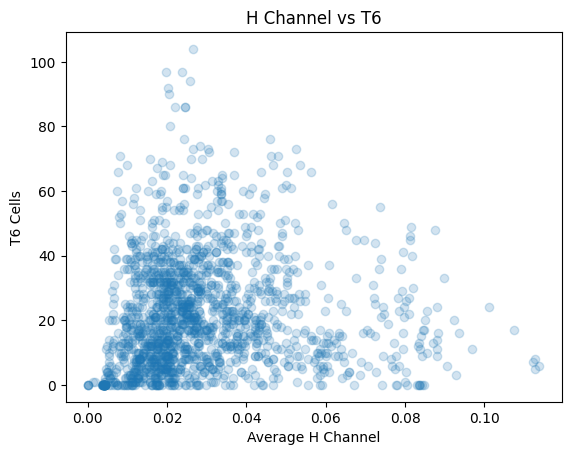

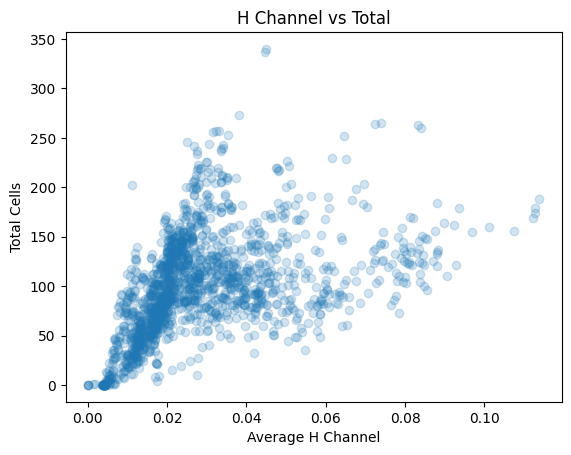

In [12]:
# scatter plots for H channel vs cell count of every type
list_cell = ["T1","T2","T3","T4","T5","T6","Total"]
for cell in list_cell:
    plt.figure()
    plt.scatter(h_channel, first_Y[cell], alpha = 0.2)
    plt.title(f"H Channel vs {cell}")
    plt.xlabel("Average H Channel")
    plt.ylabel(f"{cell} Cells")
    plt.show()

#### From the scatter plots, it is seen that the average H channel does not have any effect on the number of T1 cells. Most images have no T1 cells. The scatter plot between Average H Channel and number of T2 cells indicate a positive correlation higher than the one indicated in the scatter plot for T3 cells. T4 and T5 cells also have a very low positive effect due to the Average H channel. The scatter plot between the average H channel and the T6 cells show a more diverse plot. There is a strong positive correlation between the average H channel and the total number of cells. 
#### From the scatter plots, it is seen that the average H channel does have an impact on the cells. Hence, it is vital to the regreesion model as there is a clear linear association between the H channel and the cell counts. However, it is not a perfect relationship as there is a lot of dispersion for most graphs.

### vi) What performance metrics can you use for this problem? Which one will be the best performance metric for this problem? Please give your reasoning.

#### The performance of a regression model can be found by the error in the predictions.

#### The different performance metrics are:
#### 1. Mean Squared Error(MSE): It is calculated as the average of the square of the differences between the predicted and expected values. The larger errors are magnified resulting in a large positive error. It is used to train a regression predictive model. 
#### 2. Mean Absolute Error(MAE): It weighs all errors the same unlike MSE and RMSE as it is the average of the absolute error values. 
#### 3. Root Mean Square Error(RMSE): It is an extension of MSE where the square root of the errors are taken. It is used to train and evaluate the performance of a regression model. 
#### 4. $R^2$ Score: It shows the variability in the predicted variable by squaring the correlation coefficient. It is used to evaluate how well the model fits the predicted variable. Adjusted $R^2$ is used to overcome the overfitting problem that $R^2$ score overlooks.  

#### For using the training data to predict the cell counts of each type in the test images, it is better to use $R^2$ Score as it shows how well the model fits the predicted values.

# Question 2: Feature Extraction and Classical Regression

In [13]:
# finding the total number of cells in each image for the first and second fold
total_cells = []
for i,x in enumerate(F):
    if x != 3:
        cells = Y.iloc[i,0]+Y.iloc[i,1]+Y.iloc[i,2]+Y.iloc[i,3]+Y.iloc[i,4]+Y.iloc[i,5]
        total_cells.append(cells)

### i) Extract features from a given image. Plot the scatter plot and calculate the correlation coefficient of each feature in Q(2i,a-c) you obtain vs. the target variable (cell count) across all images. Which features do you think are important? Give your reasoning.

### a) average of the “H”, red, green and blue channels

### b) variance of the “H”, red, green and blue channels

In [14]:
# average and varaince of  H, R, G and B channels for each image in the first and second fold
h_channel_avg = []
r_channel_avg = []
g_channel_avg = []
b_channel_avg = []
h_channel_var = []
r_channel_var = []
g_channel_var = []
b_channel_var = []
for i,x in enumerate(F):
    if x != 3:
        img = X[i]
        hed = rgb2hed(img)
        avgH = np.mean(hed[:, :, 0])
        varH = np.var(hed[:, :, 0])
        h_channel_avg.append(avgH)
        h_channel_var.append(varH)
        avgR = np.mean(img[:,:,2])
        varR = np.var(img[:,:,2])
        r_channel_avg.append(avgR)
        r_channel_var.append(varR)
        avgG = np.mean(img[:,:,1])
        varG = np.var(img[:,:,1])
        g_channel_avg.append(avgG)
        g_channel_var.append(varG)
        avgB = np.mean(img[:,:,0])
        varB = np.var(img[:,:,0])
        b_channel_avg.append(avgB)
        b_channel_var.append(varB)

In [15]:
Channel_avg = [h_channel_avg, r_channel_avg, g_channel_avg, b_channel_avg]
Channel_var = [h_channel_var, r_channel_var, g_channel_var, b_channel_var]
Labels = ["H", "R", "G", "B"]

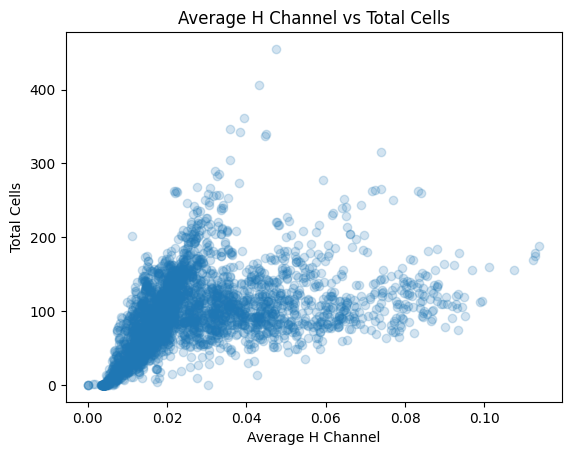

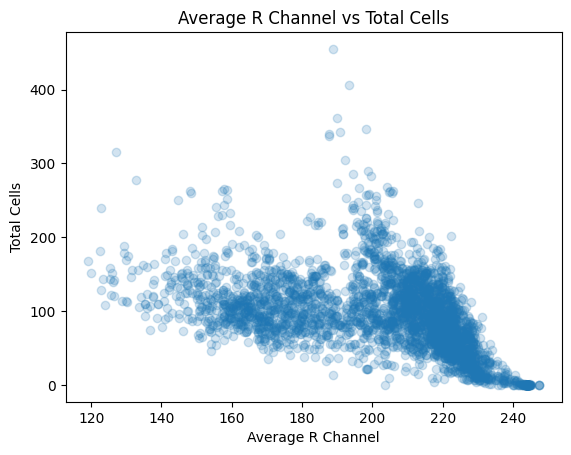

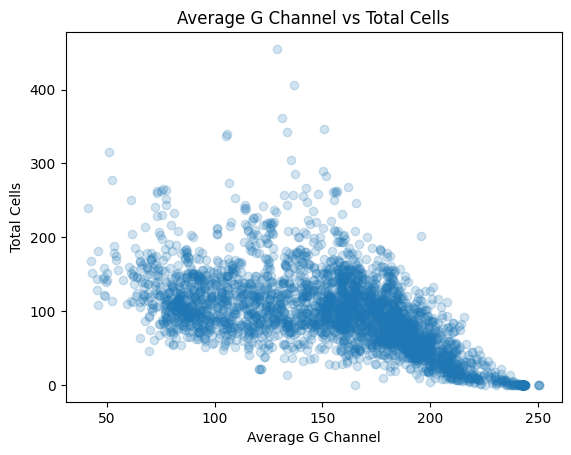

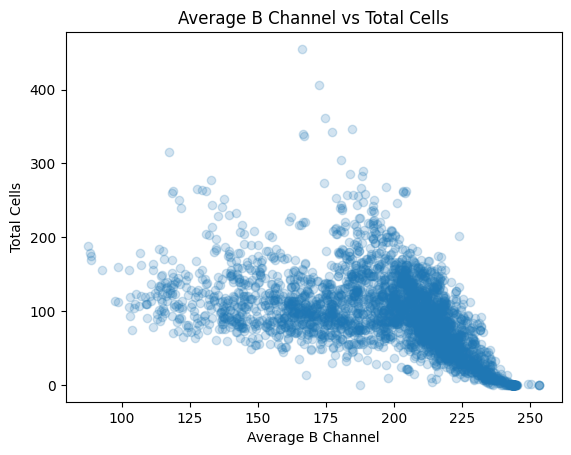

In [16]:
# scatter plots for the average H, R, G, B channels vs the total cells from first and second folds
for ic,channel in enumerate(Channel_avg):
    plt.figure()
    plt.scatter(channel, total_cells, alpha = 0.2)
    plt.title(f"Average {Labels[ic]} Channel vs Total Cells")
    plt.xlabel(f"Average {Labels[ic]} Channel")
    plt.ylabel("Total Cells")
    plt.show()

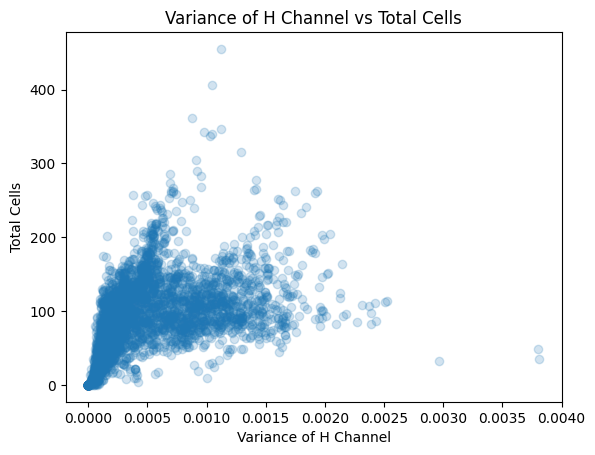

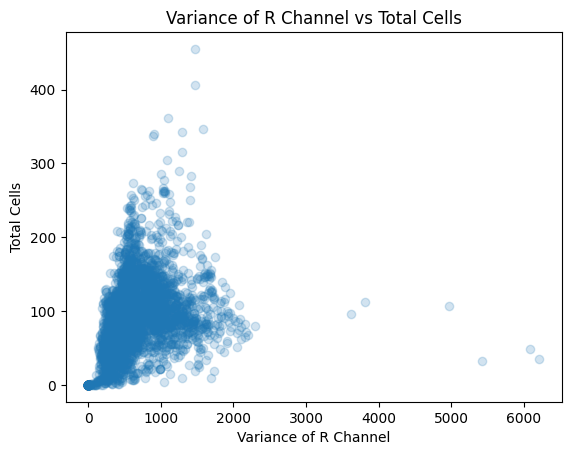

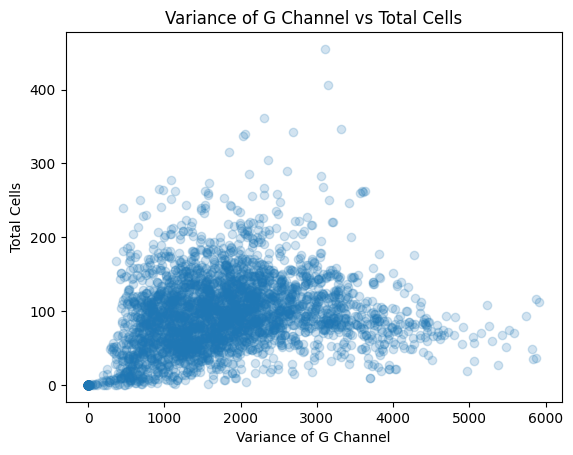

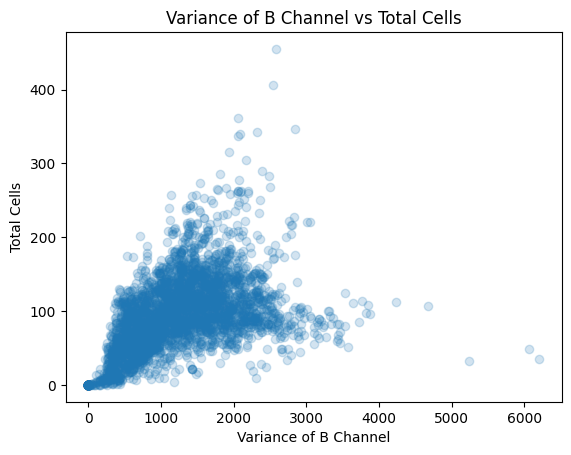

In [17]:
# scatter plots for the variance of H, R, G, B channels vs the total cells from first and second folds
for ic,channel in enumerate(Channel_var):
    plt.figure()
    plt.scatter(channel, total_cells, alpha = 0.2)
    plt.title(f"Variance of {Labels[ic]} Channel vs Total Cells")
    plt.xlabel(f"Variance of {Labels[ic]} Channel")
    plt.ylabel("Total Cells")
    plt.show()

In [18]:
# Correlation coefficients for average and variance 
ha = np.corrcoef(h_channel_avg, total_cells)
ra = np.corrcoef(r_channel_avg, total_cells)
ga = np.corrcoef(g_channel_avg, total_cells)
ba = np.corrcoef(b_channel_avg, total_cells)
hv = np.corrcoef(h_channel_var, total_cells)
rv = np.corrcoef(r_channel_var, total_cells)
gv = np.corrcoef(g_channel_var, total_cells)
bv = np.corrcoef(b_channel_var, total_cells)
table =[
    ["H Channel", ha[0,1], hv[0,1]], 
    ["R Channel", ra[0,1], rv[0,1]], 
    ["G Channel", ga[0,1], gv[0,1]], 
    ["B Channel", ba[0,1], bv[0,1]]
]
print("Correlation Coefficients for the Average and Variance of each Singular Channel against the Totoal Number of Cells")
print(tabulate(table, headers = ["Singular Channels", "Corr. Coeff of Average", "Corr. Coeff of Variance"], tablefmt="grid"))

Correlation Coefficients for the Average and Variance of each Singular Channel against the Totoal Number of Cells
+---------------------+--------------------------+---------------------------+
| Singular Channels   |   Corr. Coeff of Average |   Corr. Coeff of Variance |
+=====================+==========================+===========================+
| H Channel           |                 0.433646 |                  0.429015 |
+---------------------+--------------------------+---------------------------+
| R Channel           |                -0.467918 |                  0.286223 |
+---------------------+--------------------------+---------------------------+
| G Channel           |                -0.580089 |                  0.240499 |
+---------------------+--------------------------+---------------------------+
| B Channel           |                -0.488312 |                  0.481632 |
+---------------------+--------------------------+---------------------------+


### c) Any other features that you think can be useful for this work. Describe your reasoning for using these features

In [19]:
# extracting H, R, G, B channels from training data
h_train = []
r_train = []
g_train = []
b_train = []
for i,x in enumerate(F):
    if x != 3:
        img = X[i]
        hed = rgb2hed(img)
        h_train.append(hed[:, :, 0])
        r_train.append(img[:, :, 2])
        g_train.append(img[:, :, 1])
        b_train.append(img[:, :, 0])

In [20]:
# PCA Feature Extraction
def pca_feature(ch):
    channel = np.array(ch)
    d1, d2, d3 = channel.shape
    # 95% variance of the training dataset
    pca95 = PCA(n_components=0.95)
    pca95.fit(channel.reshape(d1, d2*d3))
    projected = pca95.transform(channel.reshape(d1, d2*d3))
    # number of dimensions
    d = pca95.n_components_
    # PCA with components explining 95% variance
    pca = PCA(n_components=d)
    pca.fit(channel.reshape(d1, d2*d3))
    pca_channel = pca.transform(channel.reshape(d1, d2*d3))
    return pca_channel

pca_h = pca_feature(h_train)
pca_r = pca_feature(r_train)
pca_g = pca_feature(g_train)
pca_b = pca_feature(b_train)

In [21]:
# finding the average of all dimesions
avg_pca_h = []
avg_pca_r = []
avg_pca_g = []
avg_pca_b = []
for i in range(3373):
    avg_pca_h.append(np.mean(pca_h[i]))
    avg_pca_r.append(np.mean(pca_r[i]))
    avg_pca_g.append(np.mean(pca_g[i]))
    avg_pca_b.append(np.mean(pca_b[i]))

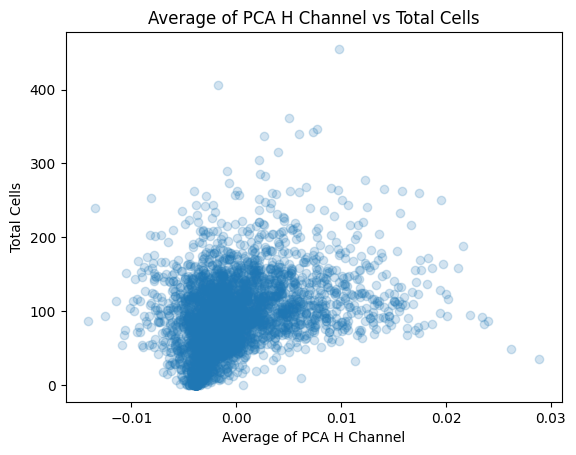

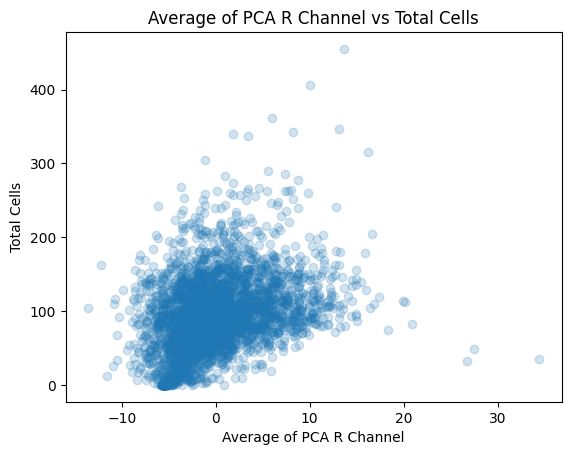

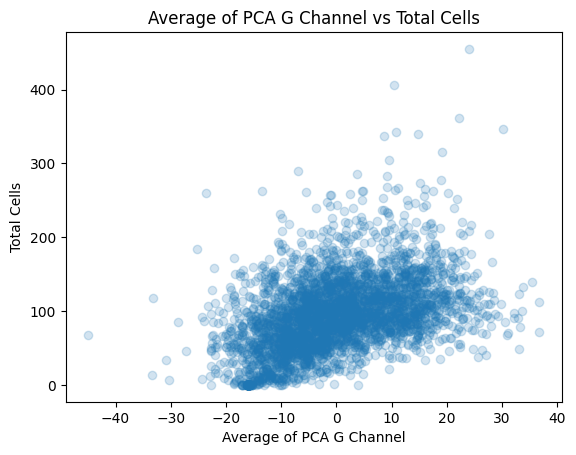

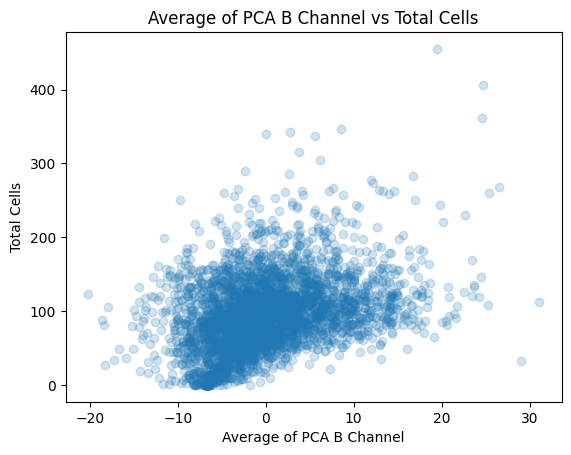

In [22]:
# scatter plots for the Average of PCA H, R, G, B channels vs the total cells from first and second folds
Channel_PCA = [avg_pca_h, avg_pca_r, avg_pca_g, avg_pca_b]
for ic,channel in enumerate(Channel_PCA):
    plt.figure()
    plt.scatter(channel, total_cells, alpha = 0.2)
    plt.title(f"Average of PCA {Labels[ic]} Channel vs Total Cells")
    plt.xlabel(f"Average of PCA {Labels[ic]} Channel")
    plt.ylabel("Total Cells")
    plt.show()

In [23]:
# Correlation coefficients for PCA
h = np.corrcoef(avg_pca_h, total_cells)
r = np.corrcoef(avg_pca_r, total_cells)
g = np.corrcoef(avg_pca_g, total_cells)
b = np.corrcoef(avg_pca_b, total_cells)
table =[
    ["H Channel", h[0,1]], 
    ["R Channel", r[0,1]], 
    ["G Channel", g[0,1]], 
    ["B Channel", b[0,1]]
]
print("Correlation Coefficients for the Average PCA of each Singular Channel against the Totoal Number of Cells")
print(tabulate(table, headers = ["Singular Channels", "Corr. Coeff of Average"], tablefmt="grid"))

Correlation Coefficients for the Average PCA of each Singular Channel against the Totoal Number of Cells
+---------------------+--------------------------+
| Singular Channels   |   Corr. Coeff of Average |
+=====================+==========================+
| H Channel           |                 0.323734 |
+---------------------+--------------------------+
| R Channel           |                 0.352129 |
+---------------------+--------------------------+
| G Channel           |                 0.448308 |
+---------------------+--------------------------+
| B Channel           |                 0.373152 |
+---------------------+--------------------------+


#### Another feature that can be used to predict the total number of cells is PCA. Here, we can extract the different channels and run each channel through PCA where the components explain 95% of the variance. The average of the values are taken to predict the total number of cells. PCA identifies the principle components in the image. Hence, each channel is reduced to its principle components. It removes any features that hardly effect the variance.
#### However, from the above graph, it is seen that there is a weak positive correlation present. Hence, it is not very effective in predicting the total number of cells in each image.

#### From the correlation coefficients of the different features and the total number of cells, it is clear that the average and variance of the H channel are the most important features in predicting the total number of cells among the others. The average and variance of RGB channels show a negative correlation with the exception of the Blue channel, which shows a positive correlation. 
#### None of the features above are good predictors of the total number of cells.

### ii) Try the following regression models with the features used in part-I. Plot the scatter plot between true and predicted counts for each type of regression model for the test data. Also, report your prediction performance in terms of RMSE, Pearson Correlation Coefficient, Spearman Correlation Coefficient and R2 score on the test data.

In [24]:
# finding total cells for the test fold (Fold 3)
TCtest = []
for i,x in enumerate(F):
    if x == 3:
        cells = Y.iloc[i,0]+Y.iloc[i,1]+Y.iloc[i,2]+Y.iloc[i,3]+Y.iloc[i,4]+Y.iloc[i,5]
        TCtest.append(cells)

In [25]:
# average and variance  of H, R, G and B channels for each image in the third fold (test fold)
h_avg_test = []
r_avg_test = []
g_avg_test = []
b_avg_test = []
h_var_test = []
r_var_test = []
g_var_test = []
b_var_test = []
for i,x in enumerate(F):
    if x == 3:
        img = X[i]
        hed = rgb2hed(img)
        avgH = np.mean(hed[:, :, 0])
        varH = np.var(hed[:, :, 0])
        h_avg_test.append(avgH)
        h_var_test.append(varH)
        avgR = np.mean(img[:,:,2])
        varR = np.var(img[:,:,2])
        r_avg_test.append(avgR)
        r_var_test.append(varR)
        avgG = np.mean(img[:,:,1])
        varG = np.var(img[:,:,1])
        g_avg_test.append(avgG)
        g_var_test.append(varG)
        avgB = np.mean(img[:,:,0])
        varB = np.mean(img[:,:,0])
        b_avg_test.append(avgB)
        b_var_test.append(varB)

In [26]:
# extracting H, R, G, B channels from test data
h_test = []
r_test = []
g_test = []
b_test = []
for i,x in enumerate(F):
    if x == 3:
        img = X[i]
        hed = rgb2hed(img)
        h_test.append(hed[:, :, 0])
        r_test.append(img[:, :, 2])
        g_test.append(img[:, :, 1])
        b_test.append(img[:, :, 0])

In [27]:
# pca for test data
testh = pca_feature(h_test)
testr = pca_feature(r_test)
testg = pca_feature(g_test)
testb = pca_feature(b_test)

In [28]:
# finding the average of all dimesions
avgh_pca = []
avgr_pca = []
avgg_pca = []
avgb_pca = []
for i in range(1608):
    avgh_pca.append(np.mean(testh[i]))
    avgr_pca.append(np.mean(testr[i]))
    avgg_pca.append(np.mean(testg[i]))
    avgb_pca.append(np.mean(testb[i]))

In [29]:
# creating a dataframe
data_train = pd.DataFrame({"Average H":h_channel_avg, "Variance H": h_channel_var, "PCA H": avg_pca_h,
                          "Average R":r_channel_avg, "Variance R": r_channel_var, "PCA R": avg_pca_r,
                          "Average G":g_channel_avg, "Variance G": g_channel_var, "PCA G": avg_pca_g,
                          "Average B":b_channel_avg, "Variance B": b_channel_var, "PCA B": avg_pca_b})
data_test = pd.DataFrame({"Average H":h_avg_test, "Variance H": h_var_test, "PCA H": avgh_pca,
                          "Average R":r_avg_test, "Variance R": r_var_test, "PCA R": avgr_pca,
                          "Average G":g_avg_test, "Variance G": g_var_test, "PCA G": avgg_pca,
                          "Average B":b_avg_test, "Variance B": b_var_test, "PCA B": avgb_pca})

### a) Ordinary Least Squares (OLS) regression

Text(0, 0.5, 'Predicted Values')

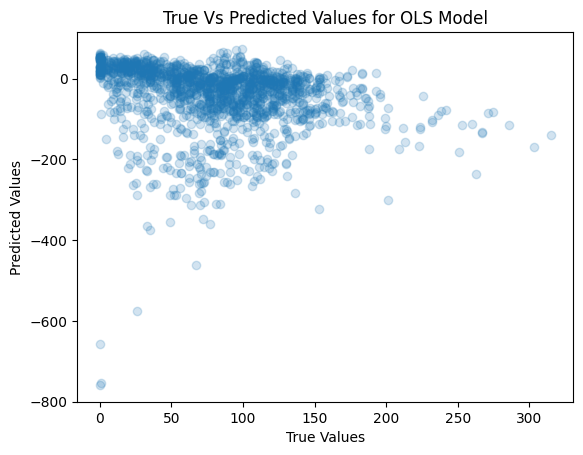

In [30]:
# OLS Model
reg = LinearRegression().fit(data_train, total_cells)

# predictions
ols_pred = reg.predict(data_test)

# performance metrices
ols_rsme = sqrt(mean_squared_error(TCtest, ols_pred))
ols_pearson = stats.pearsonr(TCtest, ols_pred)[0]
ols_spearman = stats.spearmanr(TCtest, ols_pred)[0]
ols_r2 = r2_score(TCtest, ols_pred)

# scatter plot between true and predicted counts
plt.figure()
plt.scatter(TCtest, ols_pred, alpha = 0.2)
plt.title("True Vs Predicted Values for OLS Model")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

### b) Support Vector Regression OR Multilayer Perceptron (MLP) OR Both

Text(0, 0.5, 'Predicted Values')

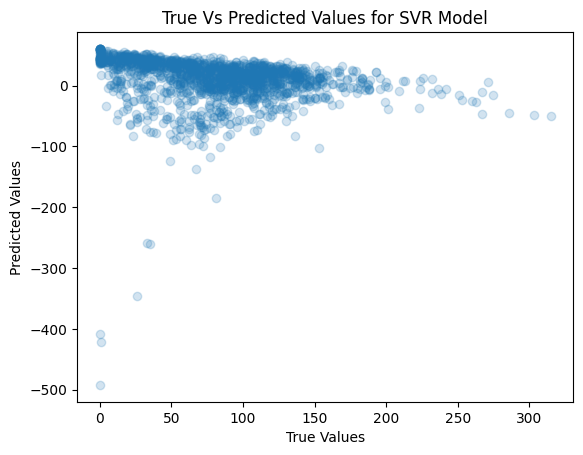

In [31]:
# SVR Model
sv = SVR(kernel='poly', degree = 1, C = 10.0).fit(data_train, total_cells)

# predictions
sv_pred = sv.predict(data_test)

# performance metrices
sv_rsme = sqrt(mean_squared_error(TCtest, sv_pred))
sv_pearson = stats.pearsonr(TCtest, sv_pred)[0]
sv_spearman = stats.spearmanr(TCtest, sv_pred)[0]
sv_r2 = r2_score(TCtest, sv_pred)

# scatter plot between true and predicted counts
plt.figure()
plt.scatter(TCtest, sv_pred, alpha = 0.2)
plt.title("True Vs Predicted Values for SVR Model")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

Text(0, 0.5, 'Predicted Values')

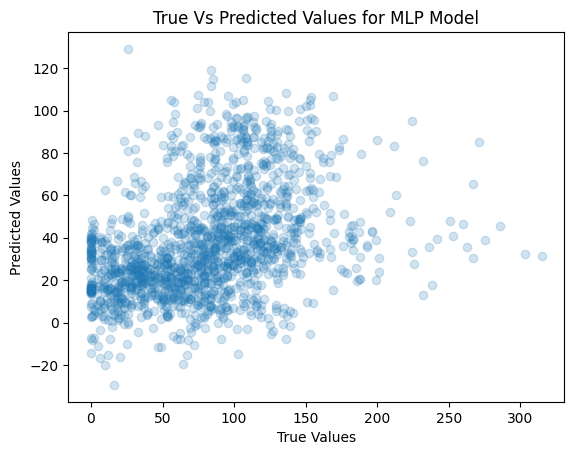

In [32]:
# MLP Model
mlp = MLPRegressor(random_state=1, max_iter=800).fit(data_train, total_cells)

# predictions
mlp_pred = mlp.predict(data_test)

# performance metrices
mlp_rsme = sqrt(mean_squared_error(TCtest, mlp_pred))
mlp_pearson = stats.pearsonr(TCtest, mlp_pred)[0]
mlp_spearman = stats.spearmanr(TCtest, mlp_pred)[0]
mlp_r2 = r2_score(TCtest, mlp_pred)

# scatter plot between true and predicted counts
plt.figure()
plt.scatter(TCtest, mlp_pred, alpha = 0.2)
plt.title("True Vs Predicted Values for MLP Model")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

In [33]:
# performance metrices table
matrix = []
matrix.append(["OLS", ols_rsme, ols_pearson, ols_spearman, ols_r2])
matrix.append(["SVR", sv_rsme, sv_pearson, sv_spearman, sv_r2])
matrix.append(["MLP", mlp_rsme, mlp_pearson, mlp_spearman, mlp_r2])
headers = ["Model", "RMSE", "Pearson", "Spearman", "R^2"]
print(tabulate(matrix, headers = headers, tablefmt="grid"))

+---------+----------+-----------+------------+-----------+
| Model   |     RMSE |   Pearson |   Spearman |       R^2 |
+=========+==========+===========+============+===========+
| OLS     | 159.224  | -0.202813 |  -0.373189 | -9.44162  |
+---------+----------+-----------+------------+-----------+
| SVR     |  97.5562 | -0.198245 |  -0.437396 | -2.91976  |
+---------+----------+-----------+------------+-----------+
| MLP     |  62.5603 |  0.379399 |   0.440855 | -0.611936 |
+---------+----------+-----------+------------+-----------+


#### Using the features in part 1, it is seen that OLS and SVR are not good models to predict the total number of cells in each image. MLP model has a positive Pearson's and Spearman's Correlation Coefficient. However, the value indicates a weak relationship.

# Question 3: Using Convolutional Neural Networks

### a) Use a convolutional neural network (in PyTorch) to solve this problem in much the same was as in part (ii) of Question (2). You are to develop an architecture of the neural network that takes an image directly as input and produces a count as the output corresponding to the total number of cells. You are free to choose any network structure as long as you can show that it gives good performance.  

In [34]:
# resizing images
resizedX = np.empty((len(X),64,64,3),dtype = "float64")
for i in range(len(X)):
    resizedX[i] = X[i,::4,::4,:]
    
# convert pixels from [1..255] to [0..1]
resizedX /= 255

#### The images have been resized to 64*64 pixels.

In [35]:
# training and testing indices
train_idx = [i for i,x in enumerate(F) if x!=3]
test_idx = [i for i,x in enumerate(F) if x==3]

In [36]:
# training and test data
TrainX = resizedX[train_idx]
TestX = resizedX[test_idx]
TrainY = np.array(total_cells)
TestY = np.array(TCtest)

In [37]:
# transforming the dimensions for training and test data
newtest = np.empty(shape=(len(TestX),3,64,64),dtype = "float64")
for i in range(len(TestX)):
    img = TestX[i]
    r = img[:,:,2]
    g = img[:,:,1]
    b = img[:,:,0]
    newtest[i][2] = r
    newtest[i][1] = g
    newtest[i][0] = b
newtrain = np.empty(shape=(len(TrainX),3,64,64),dtype = "float64")
for i in range(len(TrainX)):
    img = TrainX[i]
    r = img[:,:,2]
    g = img[:,:,1]
    b = img[:,:,0]
    newtrain[i][2] = r
    newtrain[i][1] = g
    newtrain[i][0] = b

In [38]:
# Convert to 2D PyTorch tensors
X_train = torch.tensor(newtrain, dtype=torch.float32)
y_train = torch.tensor(TrainY, dtype=torch.float32).reshape(-1, 1) # reshaping to match size of input
X_test = torch.tensor(newtest, dtype=torch.float32)
y_test = torch.tensor(TestY, dtype=torch.float32).reshape(-1, 1) # reshaping to match size of input

In [39]:
# loading the data
train_dataset = TensorDataset(X_train, y_train) 
train_dataloader = DataLoader(train_dataset, batch_size = 100, shuffle = True)

In [40]:
# Convolutional Neural Network
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # convolution layers
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.bn1 = nn.BatchNorm2d(48)
        self.conv2 = nn.Conv2d(16, 24, 3)
        self.bn2 = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(24, 36, 3)
        self.bn3 = nn.BatchNorm2d(48)
        self.conv4 = nn.Conv2d(36, 48, 3)
        self.bn4 = nn.BatchNorm2d(48)
        # fully connected layers
        self.fc1 = nn.Linear(192, 500)
        self.fc2 = nn.Linear(500, 20)
        self.fc3 = nn.Linear(20, 1)
        self.relu = nn.ReLU()
        

    def forward(self, x):
        # Max Pooling
        x = fun.max_pool2d(fun.relu(self.conv1(x)), 2)
        x = fun.max_pool2d(fun.relu(self.conv2(x)), 2)
        x = fun.max_pool2d(fun.relu(self.conv3(x)), 2)  
        x = fun.max_pool2d(fun.relu(self.conv4(x)), 2)
        x = self.bn1(x)
        x = self.bn2(x)
        x = self.bn3(x)
        x = self.bn4(x)
        x = torch.flatten(x, 1)
        # applying relu activation function
        x = fun.relu(self.fc1(x))
        x = fun.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [41]:
# training the data
cnn = CNN()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
criterion = nn.MSELoss() # loss function

loss_values = []
val_values = []

n_epochs = 200  # number of epochs to run

for epoch in range(n_epochs):
    train_loss = 0
    # running in batches
    for i,data in enumerate(train_dataloader):
        x, y = data
        optimizer.zero_grad()   # zero the gradient buffers             
        output = cnn(x)
        loss = criterion(output, y)
        train_loss += loss.item() * x.size(0) 
        loss.backward()
        optimizer.step()
            
    train_loss /= len(X_train)
    loss_values.append(train_loss)
    
    # Testing the data
    cnn.eval()
    with torch.no_grad():
        val_loss = 0
        pred = cnn(X_test)
        test_loss = criterion(pred, y_test)
        val_loss += test_loss.item() * X_test.size(0)
    val_loss /= len(X_test)
    val_values.append(val_loss)

### Report your results on the test examples by plotting the scatter plot between true and predicted counts on the test data.

Text(0, 0.5, 'Predicted Values')

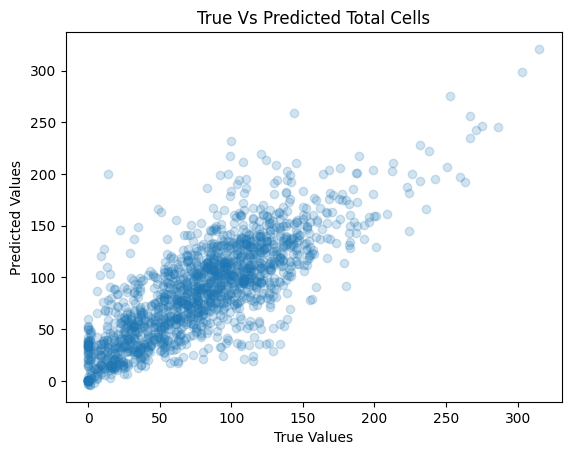

In [42]:
# scatter plot between true and predicted values
plt.scatter(y_test, pred.detach(), alpha = 0.2)
plt.title("True Vs Predicted Total Cells")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")

### Also, report your results in terms of RMSE, Pearson Correlation Coefficient, Spearman Correlation Coefficient and R2 score.

In [43]:
# performance metrices
rmse = sqrt(mean_squared_error(y_test, pred.detach()))
pear = stats.pearsonr(y_test.ravel(), pred.detach().ravel())[0]
spear = stats.spearmanr(y_test, pred.detach())[0]
r2 = r2_score(y_test, pred.detach())

In [44]:
t = []
t.append([rmse, pear, spear, r2])
h = ["RMSE", "Pearson", "Spearman", "R^2"]
print(tabulate(t, h, tablefmt="grid"))

+---------+-----------+------------+----------+
|    RMSE |   Pearson |   Spearman |      R^2 |
+=========+===========+============+==========+
| 32.1703 |  0.794611 |   0.781088 | 0.573755 |
+---------+-----------+------------+----------+


#### Since the $R^2$ score is moderatively high, the CNN model shows good performance. However, it is not the best model as the score is not very high.

### Please include convergence plots in your submission showing how does loss change over training epochs.

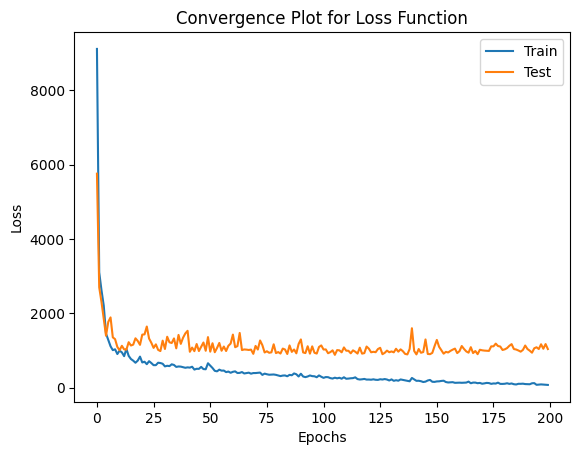

In [45]:
# convergence plots
plt.plot(loss_values, label="Train")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Convergence Plot for Loss Function")
plt.plot(val_values, label="Test")
plt.legend(loc="upper right")

#### Using 100 epochs, we can see that the loss gradually over time at a decreasing rate. For the test dataset, the loss reduces however, it is not steady over time.

### b) Use a convolutional neural network (in Pytorch) to predict the counts of 6 types of cells simultaneously given the image patch as input as well as the total number of cells (7 outputs in total). You are free to choose any network structure as long as you can show that it gives good cross-validation performance.

### Report the results for the test fold for each cell type in the form of separate predicted-vs-actual count scatter plots (3 folds, 6 cell types and 1 as the total number of cells so 21 plots in total) using your optimal machine learning model and report your results in terms of RMSE, Pearson Correlation Coefficient, Spearman Correlation Coefficient and R2 score for each cell type and the total number of cells.

In [46]:
# indices for the three folds
first_idx = [i for i,x in enumerate(F) if x==1]
second_idx = [i for i,x in enumerate(F) if x==2]
third_idx = [i for i,x in enumerate(F) if x==3]

In [47]:
# images of the three folds
X1 = resizedX[first_idx]
X2 = resizedX[second_idx]
X3 = resizedX[third_idx]

In [48]:
# finding the total cells
def row_sum(row):
    return row.T1+row.T2+row.T3+row.T4+row.T5+row.T6

Y['Total'] = Y.apply(row_sum, axis=1)

In [49]:
# cell counts of the three folds
Y1 = Y.loc[first_idx]
Y2 = Y.loc[second_idx]
Y3 = Y.loc[third_idx]

In [50]:
# transforming the dimensions of each fold
newX1 = np.empty(shape=(len(X1),3,64,64),dtype = "float64")
for i in range(len(X1)):
    img = X1[i]
    r = img[:,:,2]
    g = img[:,:,1]
    b = img[:,:,0]
    newX1[i][2] = r
    newX1[i][1] = g
    newX1[i][0] = b
newX2 = np.empty(shape=(len(X2),3,64,64),dtype = "float64")
for i in range(len(X2)):
    img = X2[i]
    r = img[:,:,2]
    g = img[:,:,1]
    b = img[:,:,0]
    newX2[i][2] = r
    newX2[i][1] = g
    newX2[i][0] = b
newX3 = np.empty(shape=(len(X3),3,64,64),dtype = "float64")
for i in range(len(X3)):
    img = X3[i]
    r = img[:,:,2]
    g = img[:,:,1]
    b = img[:,:,0]
    newX3[i][2] = r
    newX3[i][1] = g
    newX3[i][0] = b

In [51]:
# convolution neural network
class CNN_fold(nn.Module):

    def __init__(self):
        super(CNN_fold, self).__init__()
        # convolution layers
        self.conv1 = nn.Conv2d(3, 12, 3)
        self.bn1 = nn.BatchNorm2d(324)
        self.conv2 = nn.Conv2d(12, 36, 3)
        self.bn2 = nn.BatchNorm2d(324)
        self.conv3 = nn.Conv2d(36, 108, 3)
        self.bn3 = nn.BatchNorm2d(324)
        self.conv4 = nn.Conv2d(108, 324, 3)
        self.bn4 = nn.BatchNorm2d(324)
        # fully connected layers
        self.fc1 = nn.Linear(1296, 500)
        self.fc2 = nn.Linear(500, 20)
        self.fc3 = nn.Linear(20, 7)
        self.relu = nn.ReLU()


    def forward(self, x):
        # Max Pooling
        x = fun.max_pool2d(fun.relu(self.conv1(x)), 2)
        x = fun.max_pool2d(fun.relu(self.conv2(x)), 2)
        x = fun.max_pool2d(fun.relu(self.conv3(x)), 2)  
        x = fun.max_pool2d(fun.relu(self.conv4(x)), 2)
        x = self.bn1(x)
        x = self.bn2(x)
        x = self.bn3(x)
        x = self.bn4(x)
        x = torch.flatten(x, 1)
        # applying relu activation function
        x = fun.relu(self.fc1(x))
        x = fun.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Fold 1


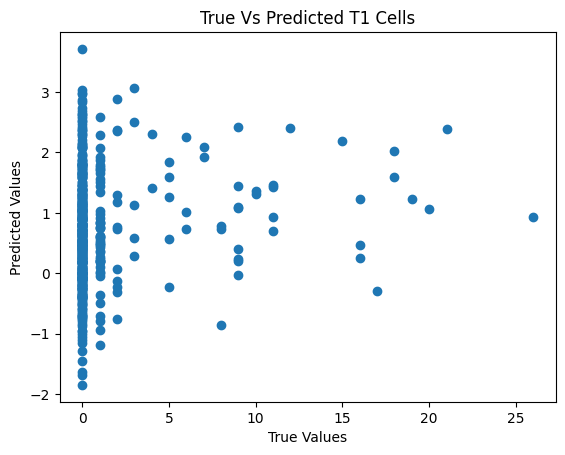

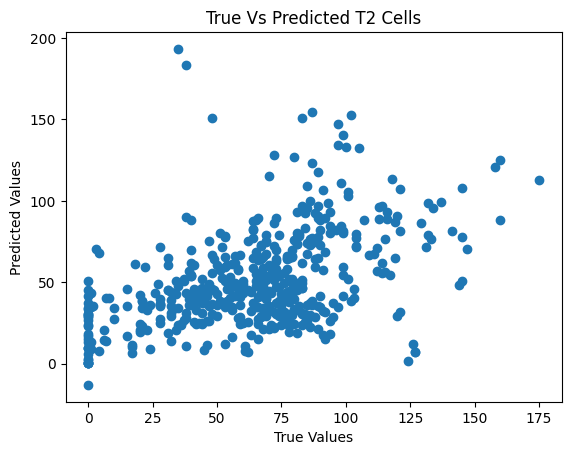

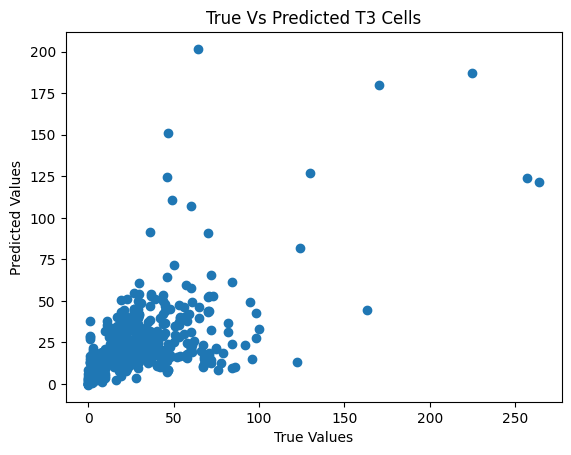

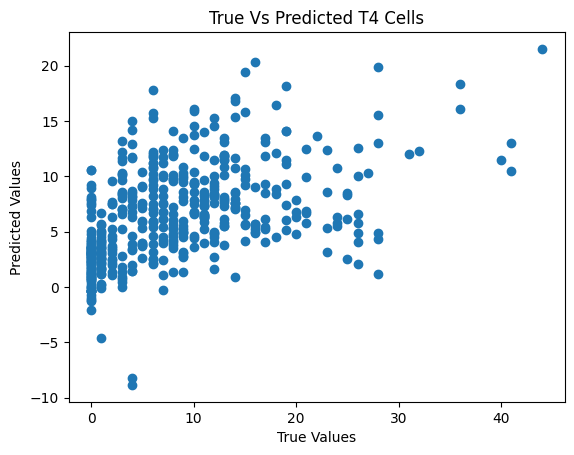

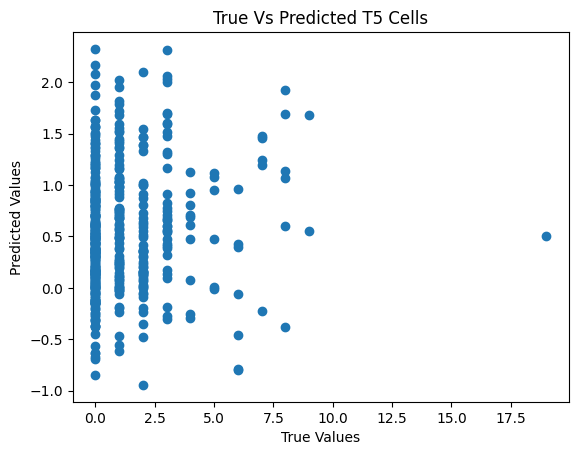

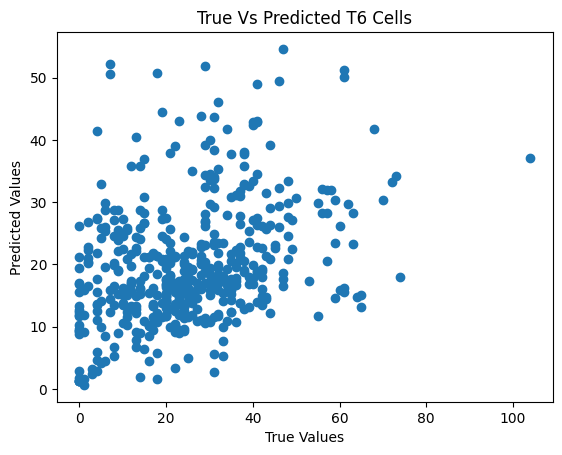

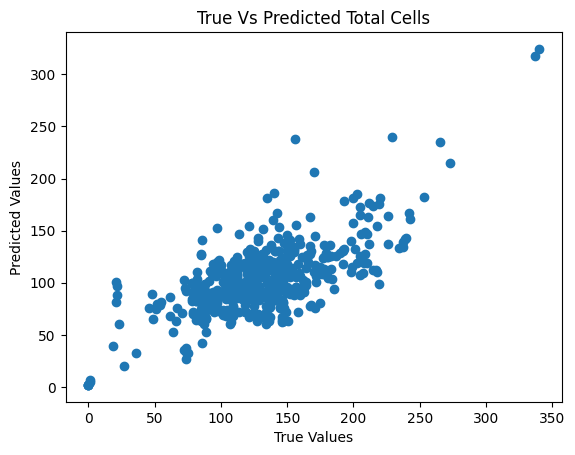

+---------+----------+-----------+------------+------------+
| Cells   |     RMSE |   Pearson |   Spearman |        R^2 |
+=========+==========+===========+============+============+
| T1      |  3.3515  |  0.137568 |   0.137778 | -0.0112209 |
+---------+----------+-----------+------------+------------+
| T2      | 35.1837  |  0.475587 |   0.47868  | -0.0889764 |
+---------+----------+-----------+------------+------------+
| T3      | 25.1647  |  0.591716 |   0.552241 |  0.291475  |
+---------+----------+-----------+------------+------------+
| T4      |  7.23965 |  0.494105 |   0.561416 |  0.18975   |
+---------+----------+-----------+------------+------------+
| T5      |  2.00969 |  0.106124 |   0.119167 | -0.122457  |
+---------+----------+-----------+------------+------------+
| T6      | 16.3858  |  0.346638 |   0.338264 | -0.0540347 |
+---------+----------+-----------+------------+------------+
| Total   | 42.3242  |  0.694979 |   0.581751 |  0.161178  |
+---------+----------+--

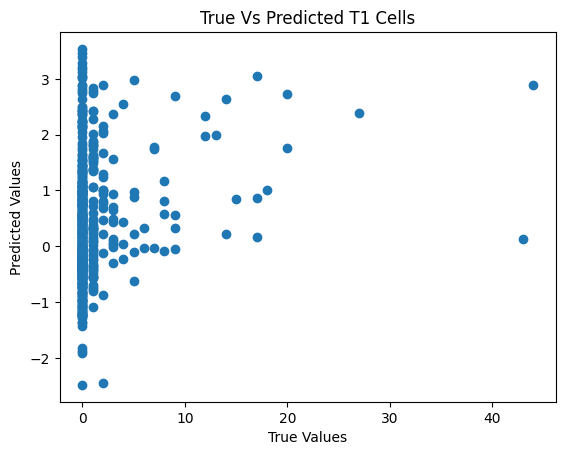

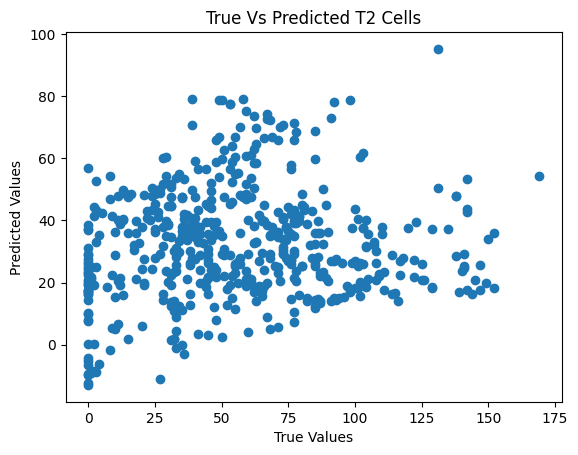

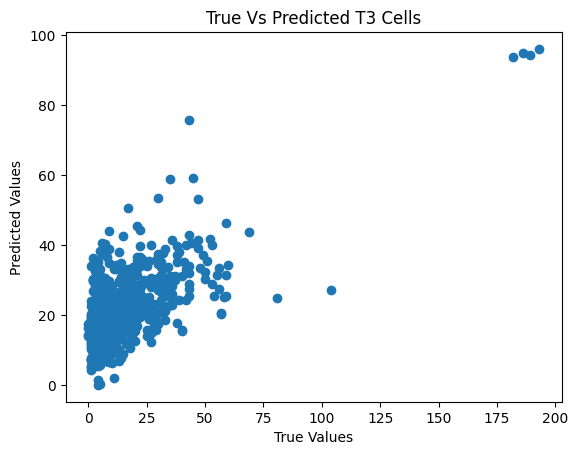

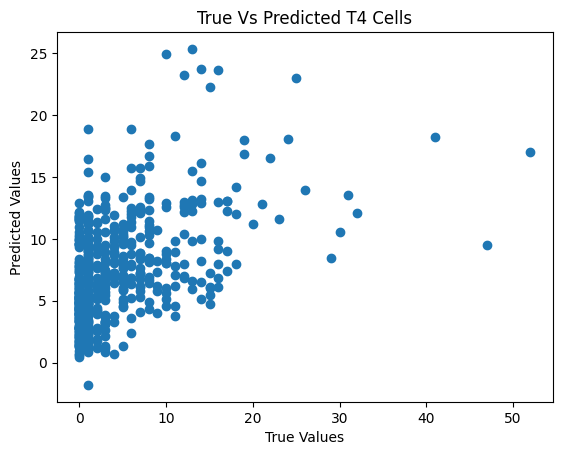

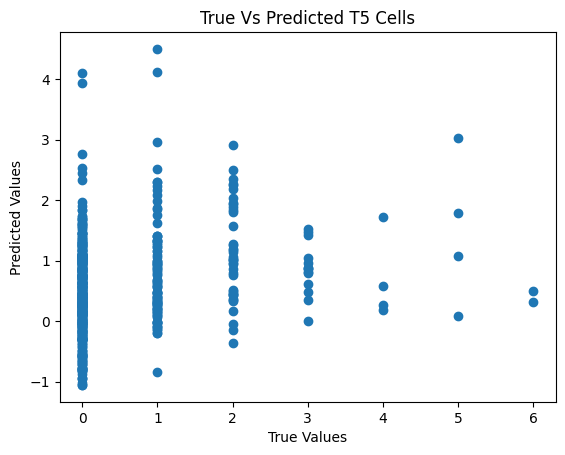

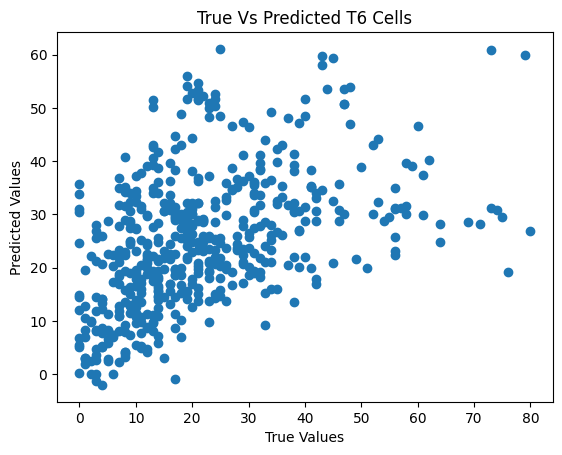

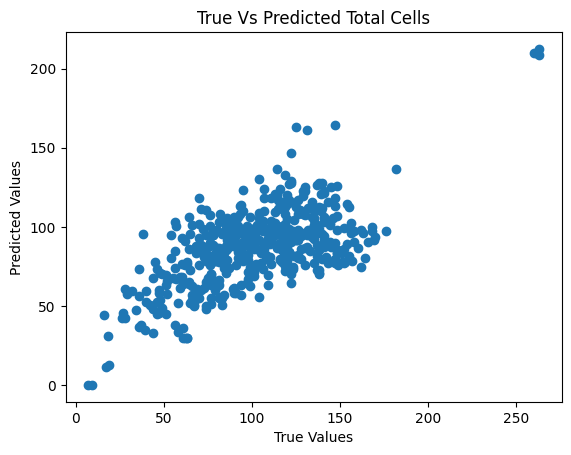

+---------+----------+-----------+------------+-------------+
| Cells   |     RMSE |   Pearson |   Spearman |         R^2 |
+=========+==========+===========+============+=============+
| T1      |  3.93595 |  0.196716 |  0.208924  |  0.00382639 |
+---------+----------+-----------+------------+-------------+
| T2      | 45.7834  |  0.112905 |  0.0719881 | -0.540373   |
+---------+----------+-----------+------------+-------------+
| T3      | 16.7314  |  0.665061 |  0.502007  |  0.354611   |
+---------+----------+-----------+------------+-------------+
| T4      |  6.51638 |  0.473782 |  0.473162  | -0.0357183  |
+---------+----------+-----------+------------+-------------+
| T5      |  1.09586 |  0.228985 |  0.245075  | -0.306511   |
+---------+----------+-----------+------------+-------------+
| T6      | 15.1159  |  0.469573 |  0.516846  |  0.0561217  |
+---------+----------+-----------+------------+-------------+
| Total   | 29.7863  |  0.656561 |  0.527048  |  0.28601    |
+-------

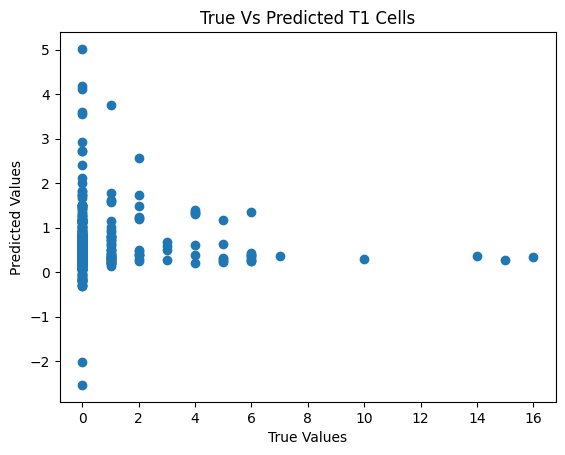

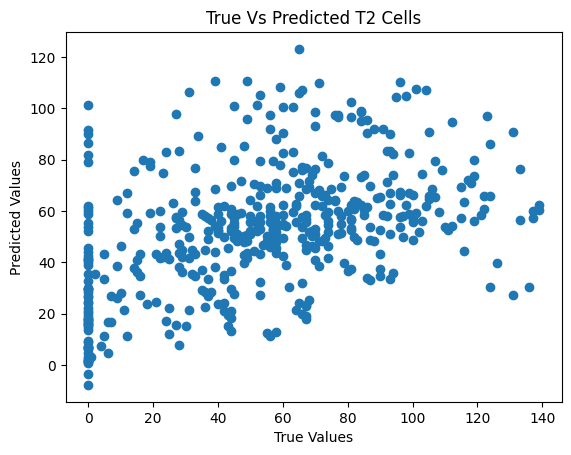

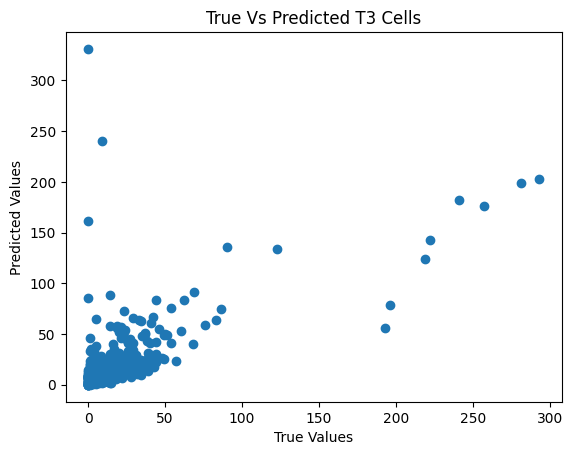

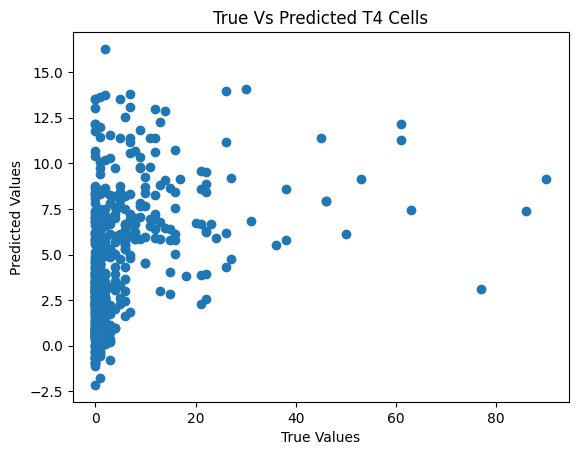

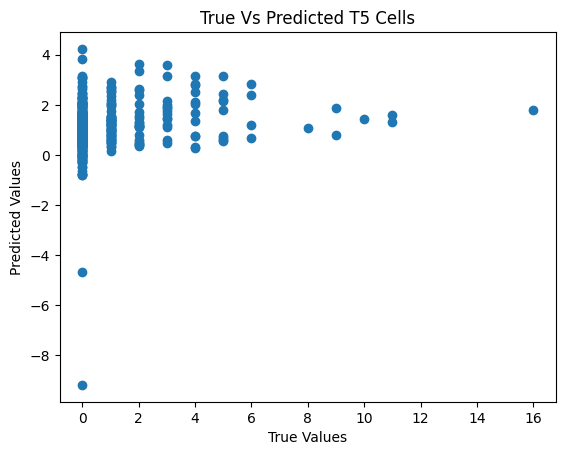

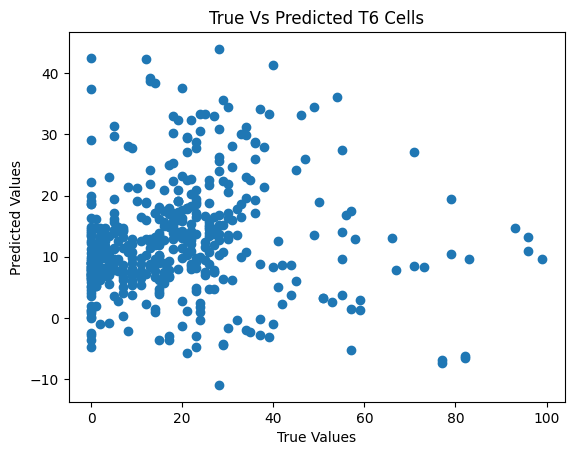

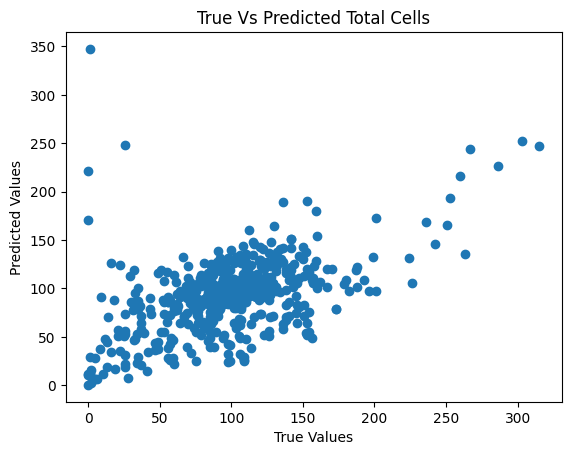

+---------+----------+------------+------------+-----------+
| Cells   |     RMSE |    Pearson |   Spearman |       R^2 |
+=========+==========+============+============+===========+
| T1      |  1.82509 | -0.0120651 |  0.0446729 | -0.142393 |
+---------+----------+------------+------------+-----------+
| T2      | 32.2287  |  0.454503  |  0.474576  |  0.148059 |
+---------+----------+------------+------------+-----------+
| T3      | 26.9176  |  0.641445  |  0.602069  |  0.317211 |
+---------+----------+------------+------------+-----------+
| T4      | 10.3386  |  0.348805  |  0.471269  |  0.117095 |
+---------+----------+------------+------------+-----------+
| T5      |  1.85731 |  0.17343   |  0.196314  | -0.169171 |
+---------+----------+------------+------------+-----------+
| T6      | 20.3744  |  0.0777098 |  0.204396  | -0.285478 |
+---------+----------+------------+------------+-----------+
| Total   | 44.5888  |  0.509662  |  0.471645  |  0.147369 |
+---------+----------+--

In [52]:
X_list = [newX1, newX2, newX3]
Y_list = [Y1, Y2, Y3]
for i in range(3):
    print(f"Fold {i+1}")   
    # train-test split of the dataset
    Xtrain, Xtest, ytrain, ytest = train_test_split(X_list[i], np.asarray(Y_list[i]), train_size=0.7, shuffle=False)
    
    # Convert to 2D PyTorch tensors
    Xtrain = torch.tensor(Xtrain, dtype=torch.float32)
    ytrain = torch.tensor(ytrain, dtype=torch.float32)
    Xtest = torch.tensor(Xtest, dtype=torch.float32)
    ytest = torch.tensor(ytest, dtype=torch.float32)
    
    # loading the data
    train_data = TensorDataset(Xtrain, ytrain) 
    train_dataload = DataLoader(train_data, batch_size = 100, shuffle = True)

    # training the data
    cnn_fold = CNN_fold()
    optimizer_fold = optim.Adam(cnn_fold.parameters(), lr=0.001)
    criterion_fold = nn.MSELoss() # loss function

    n_epochs = 150   # number of epochs to run

    for epoch in range(n_epochs):
        train_loss = 0
        # running in batches
        for i,data in enumerate(train_dataload):
            x,y = data
            optimizer_fold.zero_grad()   # zero the gradient buffers
            output = cnn_fold(x)
            loss = criterion_fold(output, y) 
            loss.backward()
            optimizer_fold.step()
                                
        # predictions
        cnn_fold.eval()
        with torch.no_grad():
            ypred = cnn_fold(Xtest)
    
    # scatter plots
    fold = []
    for idx,x in enumerate(["T1", "T2", "T3", "T4", "T5", "T6", "Total"]):
        plt.figure()
        plt.scatter(ytest[:, idx].detach(), ypred[:, idx].detach())
        plt.xlabel("True Values")
        plt.ylabel("Predicted Values")
        plt.title(f"True Vs Predicted {x} Cells")
        
        # performance metrices
        rmse = sqrt(mean_squared_error(ytest[:, idx].detach(), ypred[:, idx].detach()))
        pear = stats.pearsonr(ytest[:, idx].detach(), ypred[:, idx].detach())[0]
        spear = stats.spearmanr(ytest[:, idx].detach(), ypred[:, idx].detach())[0]
        r2 = r2_score(ytest[:, idx].detach(), ypred[:, idx].detach())
        fold.append([x, rmse, pear, spear, r2])
        
    plt.show()
        
    # consolidated performance metrices
    headers = ["Cells", "RMSE", "Pearson", "Spearman", "R^2"]
    print(tabulate(fold, headers = headers, tablefmt="grid"))

#### Not all counts of cell types can be accurately predicted using the model. The total cells can be predicted better than the rest. For different folds, there are different cell types that can be predicted better than the rest.